In [1]:
# Google Cloud Configurations
PROJECT = 'data-engineering-gcp'


# Sampling PNAD 2015

In [2]:
query_all_table="""
SELECT *
    
FROM 
    `data-engineering-gcp.PNAD_2015.join_individuals_households` 

WHERE 
    V8005_age>=18
    
ORDER BY
    household_index,V0301_inhabitant_order_in_household
    

"""

In [3]:
import pandas as pd
data_all=pd.read_gbq(query_all_table, project_id=PROJECT, index_col=None, col_order=None, reauth=False, verbose=True, 
                   private_key=None, dialect='standard')
                 

Requesting query... ok.
Job ID: 8a300d4f-9299-41df-bcb7-447843a67d5d
Query running...
  Elapsed 7.02 s. Waiting...
  Elapsed 8.33 s. Waiting...
  Elapsed 9.64 s. Waiting...
  Elapsed 10.95 s. Waiting...
  Elapsed 12.36 s. Waiting...
  Elapsed 13.67 s. Waiting...
  Elapsed 15.0 s. Waiting...
Query done.
Processed: 256.1 MB Billed: 257.0 MB
Standard price: $0.00 USD

Retrieving results...
Got 261634 rows.

Total time taken 402.1 s.
Finished at 2018-04-29 20:53:09.


In [4]:
import pandas as pd
#data.to_csv('PNAD-sample.csv')
#data = pd.read_csv('PNAD-sample.csv')
df_all = data_all


In [5]:
#df_all.info()

# Cleanup procedure
Eliminate None, and '' from the dataframe

In [6]:
#df_all = df_all.dropna(axis=0)
print(df_all.shape)

(261634, 73)


In [7]:
#df_all.sample(3)

In [8]:
df_all['monthly_family_income'].mean()

3289.5944296230614

In [9]:
df_all['Class'].unique()

array(['E', 'D', 'C', 'B', 'A', 'not declared'], dtype=object)

# Visualization of familes per social class
Using total family income

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# function to draw a bar chart showing the distribution of a variable in percentage of total
def plot_bar_chart(variable,y_label=None,title=None,color='SkyBlue',width = 0.30, x_axis_width=5,rotation=0):
    
    counter = Counter(variable.tolist())
    counter = sorted(counter.items())

    values = [i[1] for i in counter]
    values_percentage= [round((x / sum(values))*100,1) for x in list(map(float, values))]
    x_labels = [i[0] for i in counter]
    ind = np.arange(len(values))  # the x locations for the groups
    
    fig = plt.figure(figsize=(x_axis_width, 5))
    ax = fig.add_subplot(111)
  

    #fig, ax = plt.subplots()
    rects = ax.bar(ind - width/2, values_percentage, width, 
                color=color)


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(ind-width/2)
    ax.set_xticklabels(x_labels)
    plt.xticks(rotation=rotation)
    plt.yticks(np.arange(0, max(values_percentage)+5,2),visible=False)
    


    xpos = 'center'
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off
    #percentages = [x/sum(values) for x in values]

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')
    plt.show()
    
    return

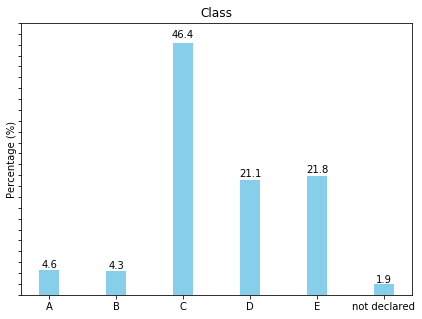

In [11]:
# Plotting a bar chart social class distribution, counting households only once
# The "drop_duplicates" of household_index is used for that.
plot_bar_chart(df_all.drop_duplicates('household_index')['Class'],
               y_label='Percentage (%)',title='Class',color='SkyBlue',width = 0.30,x_axis_width=7)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
#function for a boxplot chart to show the income distribution per social class
def print_boxplot(df,x_axis_width=7, y_axis_height=7):
    
    fig = plt.figure(figsize=(x_axis_width, y_axis_height))
    ax = fig.add_subplot(111)
    data = [df.loc[df.Class == 'E','monthly_family_income'],
            df.loc[df.Class == 'D','monthly_family_income'],
            df.loc[df.Class == 'C','monthly_family_income'],
            df.loc[df.Class == 'B','monthly_family_income'],
            df.loc[df.Class == 'A','monthly_family_income']]
    labels = ['E','D','C','B','A']
    plt.yticks(np.arange(0, data[4].max(), 2500))
    ax.boxplot(data,labels=labels,showfliers=False)
    plt.show()
    return

/home/lopasso/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


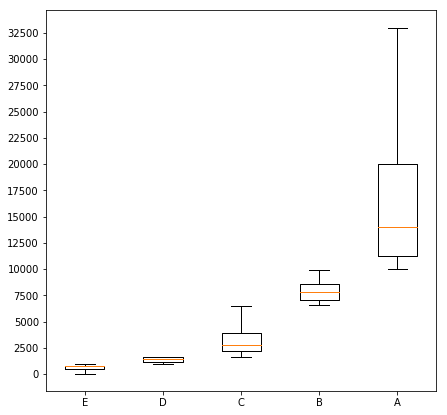

In [13]:
print_boxplot(df_all.drop_duplicates('household_index'))

## Feature Engineering

In [14]:
def clean_data(df):
  df.loc[:,'people_per_bathroom']=df.loc[:,'V4724_number_of_people_in_family']/df.loc[:,'V2016_number_of_bathrooms']
  df.loc[:,'people_per_room']=df.loc[:,'V4724_number_of_people_in_family']/df.loc[:,'V0205_number_of_rooms']
  df.loc[:,'people_per_bedroom']=df.loc[:,'V4724_number_of_people_in_family']/df.loc[:,'V0206_number_of_bedrooms']
  
  COLUMNS_TO_FLOAT = ['V4724_number_of_people_in_family','V8005_age','V2016_number_of_bathrooms','V0205_number_of_rooms',
        'V0206_number_of_bedrooms','people_per_bathroom','people_per_room','people_per_bedroom']
  df[COLUMNS_TO_FLOAT] = df[COLUMNS_TO_FLOAT].astype(np.float32)

  booleanDictionary = {True: 'True', False: 'False'}
  df.V0601_read_write =  df.V0601_read_write.replace(booleanDictionary)

  type_of_areaDictionary = {'Urban – city or town, urbanized area' : 'urban',
                            'Rural – rural zone, not conglomerate' : 'rural',
                            'Rural – rural conglomerate, isolated, town' : 'rural',
                            'urban – city or town, not urbanized area' : 'urban',
                            'Rural – conglomerate of urban extension' : 'rural',
                            'Rural – rural conglomerate, isolated, nucleos' : 'rural',
                            'Urban – isolated urban area' : 'urban',
                            'Rural – rural conglomerate, isolated, other conglomerates' : 'rural'}

  df.V4728_type_of_area =  df.V4728_type_of_area.replace(type_of_areaDictionary)
  
  df['income_range']=''
  df.loc[df['monthly_family_income'] <=6585, 'income_range']  = 'income<=6585'
  df.loc[df['monthly_family_income'] >6585,'income_range'] = 'income>6585'
  df.loc[df['Class'] =='not declared','income_range'] = 'not declared'
  
  
  df_features = ['household_index', 'UF_string', 'V0302_gender', 'V4745_highest_level_of_education', 'V8005_age',
                'V0404_race', 'V4011_marital_status', 'V0601_read_write',
                'V4715_position_at_work_last_year', 'V4816_economic_activity_last_year',
                'V4817_occupational_work_groups_last_year', 'V4723_family_type',
                'V4724_number_of_people_in_family', 'V4728_type_of_area', 
                'V0201_household_specie_a', 'V0202_household_type_a',
                'V0203_wall_material_a', 'V0204_roof_material_a',
                'V0205_number_of_rooms', 'V0206_number_of_bedrooms',
                'V0207_occupation_condition_a', 'V0210_terrain_is_owned_a',
                'V0211_water_service_a', 'V0212_water_source_a', 'V0215_bathroom',
                'V0216_shared_bathroom_a', 'V2016_number_of_bathrooms',
                'V0217_sewage_type_a', 'V0218_trash_disposal_a', 'V0219_lightening_a',
                'V0220_mobile_phone', 'V2020_fixed_phone',
                'V0221_stove_2_or_more_burners', 'V0222_stove_1_burner',
                'V0223_type_of_stove_fuel_a', 'V0224_water_filter', 'V0225_radio',
                'V0226_color_TV_set', 'V0228_fridge_type_a', 'V0229_freezer',
                'V0230_washing_machine', 'V0231_personal_computer',
                'V0232_PC_acessing_Internet', 'V2032_car_motorcycle_a','people_per_bathroom', 'people_per_room',
                'people_per_bedroom','income_range']

  df=df[df_features]
  df = df.dropna(how="any", axis=0)
  
  return df


In [15]:
df = clean_data(df_all)


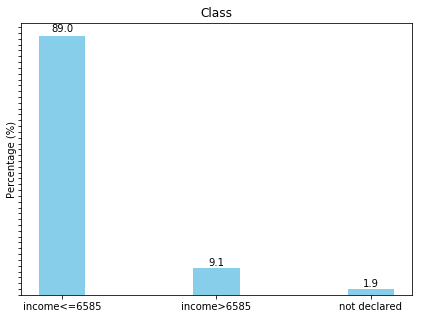

In [16]:
plot_bar_chart(df.drop_duplicates('household_index')['income_range'],
               y_label='Percentage (%)',title='Class',color='SkyBlue',width = 0.30,x_axis_width=7)

In [17]:
df.shape


(255077, 48)

# Data split into train, validation and test datasets

In [73]:
dataset_not_declared = df.loc[df['income_range']=='not declared']
dataset = df.loc[df['income_range']!='not declared'] # dataset has no more 'not declared'

print(dataset_not_declared.shape,dataset.shape)

(5383, 48) (249694, 48)


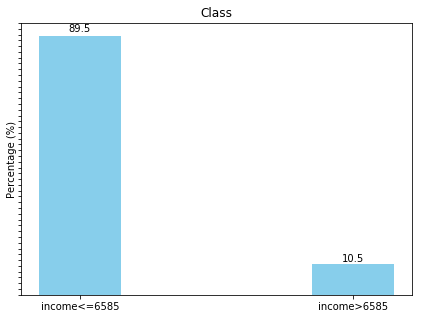

In [74]:
plot_bar_chart(dataset['income_range'],
               y_label='Percentage (%)',title='Class',color='SkyBlue',width = 0.30,x_axis_width=7)

In [76]:
# In order to avoid data leakage we are controlling individuals that will be included in each dataset(train, validation and test) 
# to be from 
# the same family, i.e., for each family, all the members will go either to train or test dataset. This will avoid that we will
# test and individuals whose family data was used to train the model using the data from another member of the same family

family_index_unique = dataset.drop_duplicates('household_index')['household_index']

test_index = family_index_unique.sample(frac=0.1)

X_features = ['UF_string',  'V4745_highest_level_of_education', 'V8005_age',
       'V0404_race', 'V4011_marital_status', 'V0601_read_write',
       'V4715_position_at_work_last_year', 'V4816_economic_activity_last_year',
       'V4817_occupational_work_groups_last_year', 'V4723_family_type',
       'V4724_number_of_people_in_family', 'V4728_type_of_area', 
       'V0201_household_specie_a', 'V0202_household_type_a',
       'V0205_number_of_rooms', 'V0206_number_of_bedrooms',
       'V0207_occupation_condition_a', 'V0210_terrain_is_owned_a',
       'V0215_bathroom', 'V0216_shared_bathroom_a', 'V2016_number_of_bathrooms',
       'V2020_fixed_phone','V0230_washing_machine', 'V0231_personal_computer',
       'V0232_PC_acessing_Internet', 'V2032_car_motorcycle_a','people_per_bathroom', 'people_per_room',
       'people_per_bedroom']
y_labels = ['income_range']

X_test = dataset.loc[dataset['household_index'].isin(test_index), X_features]
y_test = dataset.loc[dataset['household_index'].isin(test_index), y_labels]

dataset_without_test = dataset.loc[~dataset['household_index'].isin(test_index)]

In [77]:
print(X_test.shape,y_test.shape,dataset_without_test.shape)

(24941, 29) (24941, 1) (224753, 48)


In [78]:
family_index_unique2 = dataset_without_test.drop_duplicates('household_index')['household_index']

validation_index = family_index_unique2.sample(frac=0.1)

dataset_validation = dataset_without_test.loc[dataset_without_test['household_index'].isin(validation_index)]
dataset_train = dataset_without_test.loc[~dataset_without_test['household_index'].isin(validation_index)]

In [79]:
print(dataset_validation.shape,dataset_train.shape)

(22382, 48) (202371, 48)


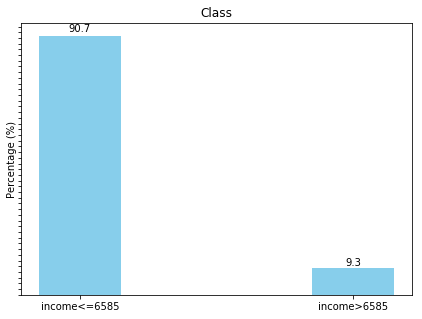

In [80]:
plot_bar_chart(dataset_train.drop_duplicates('household_index')['income_range'],
               y_label='Percentage (%)',title='Class',color='SkyBlue',width = 0.30,x_axis_width=7)

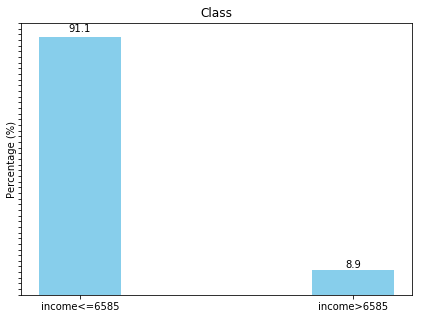

In [81]:
plot_bar_chart(dataset_validation.drop_duplicates('household_index')['income_range'],
               y_label='Percentage (%)',title='Class',color='SkyBlue',width = 0.30,x_axis_width=7)

In [82]:
#undersampling for the validation dataset
undersample = dataset_validation.loc[dataset_validation['income_range']=='income<=6585'].sample(frac=0.12)
dataset_validation = dataset_validation.loc[dataset_validation['income_range']=='income>6585'] 
dataset_validation = dataset_validation.append(undersample,ignore_index=True)

In [83]:
dataset_validation.shape


(4649, 48)

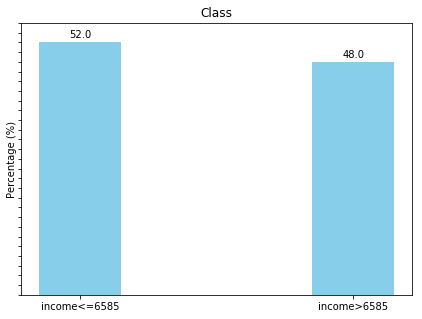

In [84]:
plot_bar_chart(dataset_validation['income_range'],
               y_label='Percentage (%)',title='Class',color='SkyBlue',width = 0.30,x_axis_width=7)

In [85]:
#undersampling for the train dataset
undersample2 = dataset_train.loc[dataset_train['income_range']=='income<=6585'].sample(frac=0.12)
dataset_train = dataset_train.loc[dataset_train['income_range']=='income>6585'] 
dataset_train = dataset_train.append(undersample2,ignore_index=True)

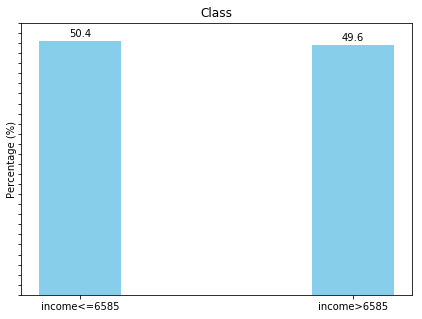

In [86]:
plot_bar_chart(dataset_train['income_range'],
               y_label='Percentage (%)',title='Class',color='SkyBlue',width = 0.30,x_axis_width=7)

In [87]:


X_validation = dataset_validation[X_features]
y_validation = dataset_validation[y_labels]

X_train = dataset_train[X_features]
y_train = dataset_train[y_labels]


In [88]:
print(X_train.shape,y_train.shape,X_validation.shape, y_validation.shape)

(43073, 29) (43073, 1) (4649, 29) (4649, 1)


# Tensorflow Deep-and-wide classification model

In [33]:
import tensorflow as tf

/home/lopasso/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [34]:
dataset.columns

Index(['household_index', 'UF_string', 'V0302_gender',
       'V4745_highest_level_of_education', 'V8005_age', 'V0404_race',
       'V4011_marital_status', 'V0601_read_write',
       'V4715_position_at_work_last_year', 'V4816_economic_activity_last_year',
       'V4817_occupational_work_groups_last_year', 'V4723_family_type',
       'V4724_number_of_people_in_family', 'V4728_type_of_area',
       'V0201_household_specie_a', 'V0202_household_type_a',
       'V0203_wall_material_a', 'V0204_roof_material_a',
       'V0205_number_of_rooms', 'V0206_number_of_bedrooms',
       'V0207_occupation_condition_a', 'V0210_terrain_is_owned_a',
       'V0211_water_service_a', 'V0212_water_source_a', 'V0215_bathroom',
       'V0216_shared_bathroom_a', 'V2016_number_of_bathrooms',
       'V0217_sewage_type_a', 'V0218_trash_disposal_a', 'V0219_lightening_a',
       'V0220_mobile_phone', 'V2020_fixed_phone',
       'V0221_stove_2_or_more_burners', 'V0222_stove_1_burner',
       'V0223_type_of_stove_fuel_

In [35]:
dataset.V0207_occupation_condition_a.unique()

array(['rented', 'owned already paid', 'owned still paying',
       'ceded other way', 'ceded by employer', 'other condition'],
      dtype=object)

In [36]:
# categorical input features


# Individual info

#gender = tf.feature_column.categorical_column_with_vocabulary_list(
#        'V0302_gender',
#        ['female', 'male'])

marital_status = tf.feature_column.categorical_column_with_vocabulary_list(
        'V4011_marital_status',
        ['single', 'legally_divorced', 'not applicable', 'married',
       'separated', 'widowed'])

# Family info

type_of_family = tf.feature_column.categorical_column_with_vocabulary_list(
        'V4723_family_type',
        ['other types of families', 'mother with all kids younger than 14',
       'couple with kids younger and older than 14',
       'couple with kids with 14 or older', 'couple without kids',
       'mother with kids with 14 or older',
       'couple with all kids younger than 14',
       'mother with kids younger and older than 14'])


# Education of the individual

highest_level_of_education = tf.feature_column.categorical_column_with_vocabulary_list(
        'V4745_highest_level_of_education',
        ['completed high school', 'incompleted elementary',
       'incompleted university degree', 'no education',
       'completed elementary', 'completed university degree',
       'indetermined', 'incompleted high school'])

read_write = tf.feature_column.categorical_column_with_vocabulary_list(
        'V0601_read_write',
        [ 'True', 'False'])

# Work of the individual

position_at_work = tf.feature_column.categorical_column_with_vocabulary_list(
        'V4715_position_at_work_last_year',
        ['Public employee', 'not applicable', 'regular employee',
       'Informal employee', 'domestic informal employee', 'self-employed',
       'working on construction for own use', 'employeer',
       'domestic formal employee', 'militar',
       'working on own consumpltion', 'not paid'])

occupational_work_groups = tf.feature_column.categorical_column_with_vocabulary_list(
        'V4817_occupational_work_groups_last_year',
        ['administrative services workers', 'technicians', 'not applicable',
       'sciences and arts professionals',
       'goods and services production workers', 'service workers',
       'agriculture workers', 'salespeople and commerce workers',
       'managers', 'military', 'badly defined occupations'])

economic_activity = tf.feature_column.categorical_column_with_vocabulary_list(
        'V4816_economic_activity_last_year',
        ['public administration', 'education, health and social services',
       'not applicable', 'transformation industry',
       'transport, storage and communication', 'commerce and repair',
       'lodging and catering', 'domestic services',
       'other collective services, social and personal', 'agriculture',
       'construction', 'other manufacturing activities',
       'other activities', 'badly defined activities'])

#Location of the household and type

state = tf.feature_column.categorical_column_with_vocabulary_list(
        'UF_string',
       ['Rondônia', 'Acre', 'Amazonas', 'Roraima', 'Pará', 'Amapá',
       'Tocantins', 'Maranhão', 'Piauí', 'Ceará', 'Rio Grande do Norte',
       'Paraíba', 'Pernambuco', 'Alagoas', 'Sergipe', 'Bahia',
       'Minas Gerais', 'Espírito Santo', 'Rio de Janeiro', 'São Paulo',
       'Paraná', 'Santa Catarina', 'Rio Grande do Sul',
       'Mato Grosso do Sul', 'Mato Grosso', 'Goiás', 'Distrito Federal'])

type_of_census_area = tf.feature_column.categorical_column_with_vocabulary_list(
        'V4728_type_of_area',
        ['urban','rural'])


household_type = tf.feature_column.categorical_column_with_vocabulary_list(
        'V0202_household_type_a',
        ['House', 'Apartment', 'Room'])

household_occupation_condition = tf.feature_column.categorical_column_with_vocabulary_list(
        'V0207_occupation_condition_a',
        ['rented', 'owned already paid', 'owned still paying',
       'ceded by employer', 'ceded other way', 'other condition'])

#census_area = tf.feature_column.categorical_column_with_hash_bucket('UPA_census_area',hash_bucket_size=100, dtype=tf.string)

# household goods

car_motorcycle = tf.feature_column.categorical_column_with_vocabulary_list(
        'V2032_car_motorcycle_a',
        ['Car', 'Motorcycle', 'Car and motorcycle', 'No'])

PC_acessing_Internet = tf.feature_column.categorical_column_with_vocabulary_list(
        'V0232_PC_acessing_Internet',
        ['true', 'not applicable', 'false'])

personal_computer = tf.feature_column.categorical_column_with_vocabulary_list(
        'V0231_personal_computer',
        ['true', 'not applicable', 'false'])

washing_machine = tf.feature_column.categorical_column_with_vocabulary_list(
        'V0230_washing_machine',
        ['true', 'not applicable', 'false'])

fixed_phone = tf.feature_column.categorical_column_with_vocabulary_list(
        'V2020_fixed_phone',
        ['true', 'not applicable', 'false'])

In [37]:
# numerical input features

# Individual
age = tf.feature_column.numeric_column('V8005_age')
age_buckets = tf.feature_column.bucketized_column(age,boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])

# Family
number_of_people_in_the_family = tf.feature_column.numeric_column('V4724_number_of_people_in_family')
number_of_people_buckets = tf.feature_column.bucketized_column(number_of_people_in_the_family,
                                                  boundaries=[1,2,3,4,5,7,10])

# Household
number_of_bathrooms = tf.feature_column.numeric_column('V2016_number_of_bathrooms')
number_of_rooms = tf.feature_column.numeric_column('V0205_number_of_rooms')
number_of_bedrooms = tf.feature_column.numeric_column('V0206_number_of_bedrooms')
people_per_bathroom = tf.feature_column.numeric_column('people_per_bathroom')
people_per_room = tf.feature_column.numeric_column('people_per_room')
people_per_bedroom = tf.feature_column.numeric_column('people_per_bedroom')



In [38]:
#print(number_of_people_in_the_family)

In [39]:
wide_columns = [
  
      tf.feature_column.crossed_column(
          [ type_of_census_area,state,household_type,household_occupation_condition], hash_bucket_size=1000),
      tf.feature_column.crossed_column(
          [household_type, number_of_people_buckets], hash_bucket_size=200),
      tf.feature_column.crossed_column(
          [age_buckets, highest_level_of_education], hash_bucket_size=int(1e3)),
      tf.feature_column.crossed_column(
          [age_buckets, read_write], hash_bucket_size=int(1e3)),
      tf.feature_column.crossed_column(
          [position_at_work, economic_activity, occupational_work_groups], hash_bucket_size=int(1e3)),
        tf.feature_column.crossed_column(
          [car_motorcycle,PC_acessing_Internet, personal_computer, washing_machine, fixed_phone], hash_bucket_size=int(200)),
      tf.feature_column.crossed_column(
          [age_buckets, highest_level_of_education, type_of_census_area], hash_bucket_size=int(500)),
      car_motorcycle,
      PC_acessing_Internet,
      personal_computer,
      washing_machine,
      fixed_phone,
      highest_level_of_education,
      read_write,
      position_at_work,
      economic_activity,
      #type_of_family,
      #census_area
]

In [40]:
deep_columns = [  
      tf.feature_column.indicator_column(car_motorcycle),
      tf.feature_column.indicator_column(PC_acessing_Internet),
      tf.feature_column.indicator_column(personal_computer),
      tf.feature_column.indicator_column(washing_machine),
      tf.feature_column.indicator_column(fixed_phone),
      tf.feature_column.indicator_column(highest_level_of_education),
      tf.feature_column.indicator_column(read_write),
      tf.feature_column.indicator_column(position_at_work),
      tf.feature_column.indicator_column(economic_activity),
      #tf.feature_column.indicator_column(type_of_family),
      #tf.feature_column.embedding_column(census_area, dimension=8),
      number_of_people_in_the_family,
      age,
      number_of_bathrooms,
      number_of_rooms,
      number_of_bedrooms,
      people_per_bathroom,
      people_per_room,
      people_per_bedroom 
]


In [90]:
import time
MODEL_DIR = "PNAD_%s" % (int(time.time()))
print(MODEL_DIR)
config=tf.contrib.learn.RunConfig(
        save_checkpoints_steps=250,
        save_checkpoints_secs=None,
        save_summary_steps=100,
    )



PNAD_1525049347


In [91]:
estimator = tf.estimator.DNNLinearCombinedClassifier(
    linear_feature_columns=wide_columns,
      dnn_feature_columns=deep_columns,
      dnn_hidden_units=[200,50],n_classes=2,
    label_vocabulary=["income<=6585", "income>6585"],
    config=config,model_dir=MODEL_DIR)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7effc87d6be0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': 250, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'PNAD_1525049347'}


### Input function

In [92]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=100,num_epochs=10000,shuffle=True)

## Train model

In [93]:
init = tf.global_variables_initializer()
estimator.train(input_fn=input_func,steps=50000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:loss = 353.50385, step = 1
INFO:tensorflow:global_step/sec: 27.7775
INFO:tensorflow:loss = 1.4693155, step = 101 (3.602 sec)
INFO:tensorflow:global_step/sec: 41.3195
INFO:tensorflow:loss = 12.321781, step = 201 (2.420 sec)
INFO:tensorflow:Saving checkpoints for 251 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 29.8079
INFO:tensorflow:loss = 1.8068557, step = 301 (3.357 sec)
INFO:tensorflow:global_step/sec: 41.9801
INFO:tensorflow:loss = 35.825912, step = 401 (2.381 sec)
INFO:tensorflow:Saving checkpoints for 501 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 31.0691
INFO:tensorflow:loss = 3.6553988, step = 501 (3.220 sec)
INFO:tensorflow:global_step/sec: 42.0891
INFO:tensorflow:loss = 119.42775, step = 601 (2.375 sec)
INFO:tensorflow:global_step/sec: 42.2985
INFO:tensorflow:loss = 3.4403791, step = 701 (2.364 sec)
I

INFO:tensorflow:loss = 11.470337, step = 6301 (3.183 sec)
INFO:tensorflow:global_step/sec: 42.6023
INFO:tensorflow:loss = 5.064629, step = 6401 (2.347 sec)
INFO:tensorflow:Saving checkpoints for 6501 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 31.3517
INFO:tensorflow:loss = 18.437267, step = 6501 (3.190 sec)
INFO:tensorflow:global_step/sec: 42.3235
INFO:tensorflow:loss = 11.440885, step = 6601 (2.363 sec)
INFO:tensorflow:global_step/sec: 42.9201
INFO:tensorflow:loss = 18.504017, step = 6701 (2.330 sec)
INFO:tensorflow:Saving checkpoints for 6751 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 31.4618
INFO:tensorflow:loss = 9.326849, step = 6801 (3.178 sec)
INFO:tensorflow:global_step/sec: 42.5211
INFO:tensorflow:loss = 37.259926, step = 6901 (2.352 sec)
INFO:tensorflow:Saving checkpoints for 7001 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 31.1259
INFO:tensorflow:loss = 9.026836, step = 7001 (3.213 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 41.9732
INFO:tensorflow:loss = 40.973026, step = 12701 (2.382 sec)
INFO:tensorflow:Saving checkpoints for 12751 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 31.1481
INFO:tensorflow:loss = 11.954038, step = 12801 (3.210 sec)
INFO:tensorflow:global_step/sec: 42.4005
INFO:tensorflow:loss = 60.698566, step = 12901 (2.359 sec)
INFO:tensorflow:Saving checkpoints for 13001 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 31.5525
INFO:tensorflow:loss = 15.391085, step = 13001 (3.169 sec)
INFO:tensorflow:global_step/sec: 42.2138
INFO:tensorflow:loss = 90.10318, step = 13101 (2.370 sec)
INFO:tensorflow:global_step/sec: 42.2547
INFO:tensorflow:loss = 17.994295, step = 13201 (2.368 sec)
INFO:tensorflow:Saving checkpoints for 13251 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 31.1809
INFO:tensorflow:loss = 20.78127, step = 13301 (3.205 sec)
INFO:tensorflow:global_step/sec: 41.4653
INFO:tensorflow:loss = 37.6

INFO:tensorflow:Saving checkpoints for 19001 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 28.318
INFO:tensorflow:loss = 27.139332, step = 19001 (3.531 sec)
INFO:tensorflow:global_step/sec: 34.7507
INFO:tensorflow:loss = 13.157038, step = 19101 (2.877 sec)
INFO:tensorflow:global_step/sec: 41.4843
INFO:tensorflow:loss = 36.574837, step = 19201 (2.411 sec)
INFO:tensorflow:Saving checkpoints for 19251 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 30.8399
INFO:tensorflow:loss = 15.593042, step = 19301 (3.243 sec)
INFO:tensorflow:global_step/sec: 34.927
INFO:tensorflow:loss = 34.130768, step = 19401 (2.863 sec)
INFO:tensorflow:Saving checkpoints for 19501 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 30.8575
INFO:tensorflow:loss = 16.289778, step = 19501 (3.242 sec)
INFO:tensorflow:global_step/sec: 42.2819
INFO:tensorflow:loss = 34.911507, step = 19601 (2.364 sec)
INFO:tensorflow:global_step/sec: 42.7112
INFO:tensorflow:loss = 15.1

INFO:tensorflow:Saving checkpoints for 25251 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 31.03
INFO:tensorflow:loss = 13.929147, step = 25301 (3.223 sec)
INFO:tensorflow:global_step/sec: 42.3205
INFO:tensorflow:loss = 40.6097, step = 25401 (2.363 sec)
INFO:tensorflow:Saving checkpoints for 25501 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 31.073
INFO:tensorflow:loss = 19.060532, step = 25501 (3.218 sec)
INFO:tensorflow:global_step/sec: 42.1721
INFO:tensorflow:loss = 67.00563, step = 25601 (2.372 sec)
INFO:tensorflow:global_step/sec: 42.3952
INFO:tensorflow:loss = 20.728222, step = 25701 (2.358 sec)
INFO:tensorflow:Saving checkpoints for 25751 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 31.3267
INFO:tensorflow:loss = 46.292435, step = 25801 (3.192 sec)
INFO:tensorflow:global_step/sec: 42.3214
INFO:tensorflow:loss = 28.557854, step = 25901 (2.363 sec)
INFO:tensorflow:Saving checkpoints for 26001 into PNAD_1525049347/model.

INFO:tensorflow:global_step/sec: 31.505
INFO:tensorflow:loss = 30.472158, step = 31501 (3.216 sec)
INFO:tensorflow:global_step/sec: 41.2555
INFO:tensorflow:loss = 14.84435, step = 31601 (2.382 sec)
INFO:tensorflow:global_step/sec: 42.5836
INFO:tensorflow:loss = 23.197393, step = 31701 (2.348 sec)
INFO:tensorflow:Saving checkpoints for 31751 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 31.3366
INFO:tensorflow:loss = 18.819618, step = 31801 (3.191 sec)
INFO:tensorflow:global_step/sec: 40.8605
INFO:tensorflow:loss = 36.49076, step = 31901 (2.448 sec)
INFO:tensorflow:Saving checkpoints for 32001 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 31.2351
INFO:tensorflow:loss = 18.740305, step = 32001 (3.245 sec)
INFO:tensorflow:global_step/sec: 41.8857
INFO:tensorflow:loss = 23.72232, step = 32101 (2.345 sec)
INFO:tensorflow:global_step/sec: 42.1962
INFO:tensorflow:loss = 17.456833, step = 32201 (2.369 sec)
INFO:tensorflow:Saving checkpoints for 32251 int

INFO:tensorflow:global_step/sec: 31.2189
INFO:tensorflow:loss = 23.948898, step = 37801 (3.204 sec)
INFO:tensorflow:global_step/sec: 42.3217
INFO:tensorflow:loss = 50.67508, step = 37901 (2.363 sec)
INFO:tensorflow:Saving checkpoints for 38001 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 31.7948
INFO:tensorflow:loss = 26.820898, step = 38001 (3.187 sec)
INFO:tensorflow:global_step/sec: 41.7652
INFO:tensorflow:loss = 48.47, step = 38101 (2.352 sec)
INFO:tensorflow:global_step/sec: 42.7304
INFO:tensorflow:loss = 18.345432, step = 38201 (2.341 sec)
INFO:tensorflow:Saving checkpoints for 38251 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 31.2841
INFO:tensorflow:loss = 39.40531, step = 38301 (3.196 sec)
INFO:tensorflow:global_step/sec: 42.3547
INFO:tensorflow:loss = 30.695942, step = 38401 (2.361 sec)
INFO:tensorflow:Saving checkpoints for 38501 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 31.7603
INFO:tensorflow:loss = 26.60077

INFO:tensorflow:global_step/sec: 41.5018
INFO:tensorflow:loss = 32.658596, step = 44101 (2.366 sec)
INFO:tensorflow:global_step/sec: 42.2786
INFO:tensorflow:loss = 35.017883, step = 44201 (2.366 sec)
INFO:tensorflow:Saving checkpoints for 44251 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 29.912
INFO:tensorflow:loss = 19.189888, step = 44301 (3.346 sec)
INFO:tensorflow:global_step/sec: 40.3575
INFO:tensorflow:loss = 29.131168, step = 44401 (2.474 sec)
INFO:tensorflow:Saving checkpoints for 44501 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 31.5496
INFO:tensorflow:loss = 22.753542, step = 44501 (3.213 sec)
INFO:tensorflow:global_step/sec: 41.9562
INFO:tensorflow:loss = 38.99241, step = 44601 (2.341 sec)
INFO:tensorflow:global_step/sec: 42.479
INFO:tensorflow:loss = 24.218246, step = 44701 (2.354 sec)
INFO:tensorflow:Saving checkpoints for 44751 into PNAD_1525049347/model.ckpt.
INFO:tensorflow:global_step/sec: 31.4118
INFO:tensorflow:loss = 33.46

## Evaluate Model

In [94]:
eval_input_func = tf.estimator.inputs.pandas_input_fn(x=X_validation,y=y_validation,batch_size=100,num_epochs=1,shuffle=False)

In [95]:
results = estimator.evaluate(eval_input_func)

INFO:tensorflow:Starting evaluation at 2018-04-30-01:14:31
INFO:tensorflow:Restoring parameters from PNAD_1525049347/model.ckpt-50000
INFO:tensorflow:Finished evaluation at 2018-04-30-01:14:34
INFO:tensorflow:Saving dict for global step 50000: accuracy = 0.8550226, accuracy_baseline = 0.52011186, auc = 0.92892265, auc_precision_recall = 0.9179026, average_loss = 0.3397268, global_step = 50000, label/mean = 0.47988814, loss = 33.604042, prediction/mean = 0.48905998


In [99]:
def prediction (X_prediction): 
  pred_fn = tf.estimator.inputs.pandas_input_fn(x=X_prediction,batch_size=len(X_prediction),shuffle=False)
  predictions = list(estimator.predict(input_fn=pred_fn))
  final_preds = []
  for pred in predictions:
      final_preds.append(pred['classes'][0].decode('utf8'))
  
  return final_preds


In [100]:
final_preds = prediction(X_validation)


INFO:tensorflow:Restoring parameters from PNAD_1525049347/model.ckpt-50000


In [101]:
def plot_confusion_matrix(final_preds,y):
  from sklearn.metrics import confusion_matrix
  import seaborn as sns
  from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

  y_size = len(y)
  confusion = confusion_matrix(y, final_preds)
  confusion = np.around(confusion/y_size, decimals=3)

  df_cm = pd.DataFrame(confusion*100, 
                     index = ['income<=6585','income>6585'], columns = ['income<=6585','income>6585'])

  plt.figure(figsize=(8,7))
  sns.heatmap(df_cm, annot=True,cmap='Reds', fmt='g')

  plt.title('Wide & Deep Tensorflow model \n\nAccuracy:{0:.1f}\n'.format(accuracy_score(y, final_preds)*100))
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  return

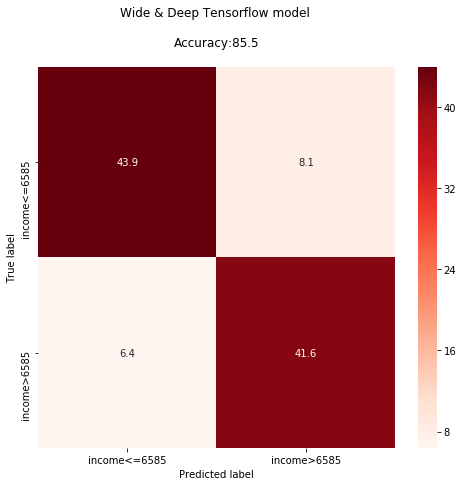

In [102]:
plot_confusion_matrix(final_preds, y_validation)

# Test model

In [103]:
test_preds = prediction(X_test)


INFO:tensorflow:Restoring parameters from PNAD_1525049347/model.ckpt-50000


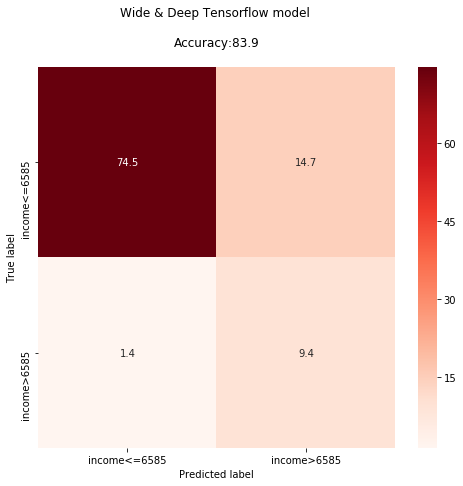

In [104]:
plot_confusion_matrix(test_preds, y_test)

## Tensorboard analysis

In [111]:
#from google.datalab.ml import TensorBoard as tb
#tb.start(MODEL_DIR)

In [112]:
#tb.stop


# Check the 'not declared' income cases

In [107]:
df_preds = prediction(dataset_not_declared)

INFO:tensorflow:Restoring parameters from PNAD_1525049347/model.ckpt-50000


In [108]:
df_preds = pd.DataFrame(df_preds, columns=['Predictions'])

In [109]:
df_preds.shape

(5383, 1)

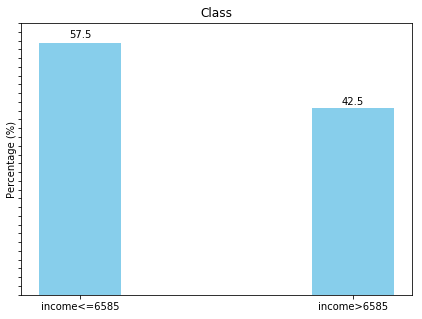

In [110]:
plot_bar_chart(df_preds['Predictions'],
               y_label='Percentage (%)',title='Class',color='SkyBlue',width = 0.30,x_axis_width=7)